In [1]:
import spacy
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim
from tqdm import tqdm
import numpy as np
import gzip

In [2]:
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

```python
import smart_open

def load_glove_model(File):
    print("Loading Glove Model")
    
    glove_model = {}
    with gzip.open(File,'rt') as f:
        for line in tqdm(f):
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
        
    print(f"{len(glove_model)} words loaded!")
    return glove_model

def save_word2vec_format(fname, vocab, vector_size, binary=True):
    """Store the input-hidden weight matrix in the same format used by the original
    C word2vec-tool, for compatibility.

    Parameters
    ----------
    fname : str
        The file path used to save the vectors in.
    vocab : dict
        The vocabulary of words.
    vector_size : int
        The number of dimensions of word vectors.
    binary : bool, optional
        If True, the data wil be saved in binary word2vec format, else it will be saved in plain text.


    """
    
    total_vec = len(vocab)
    with smart_open.open(fname, 'wb') as fout:
        print(total_vec, vector_size)
        fout.write(gensim.utils.to_utf8("%s %s\n" % (total_vec, vector_size)))
        # store in sorted order: most frequent words at the top
        for word, row in tqdm(vocab.items()):
            if binary:
                row = row.astype(np.float32)
                fout.write(gensim.utils.to_utf8(word) + row.tobytes())
            else:
                fout.write(gensim.utils.to_utf8("%s %s\n" % (word, ' '.join(repr(val) for val in row))))

                
                
glove_model = load_glove_model('./glove-sbwc.i25.vec.gz')                
save_word2vec_format(binary=False,
                     fname='glovin.bin',
                     vocab=glove_model,
                     vector_size=300)
```

%%time
model_c = gensim.models.KeyedVectors.load_word2vec_format('./glove-sbwc.i25.vec.gz',
                                                        binary=False)

name_model = "Chile/CHILE_2020_dev210721_113361_lg.model"

model_b = KeyedVectors.load(name_model) 

In [4]:
%%time
model = gensim.models.KeyedVectors.load_word2vec_format('glovin.bin',
                                                        binary=False)

CPU times: user 1min 43s, sys: 2.28 s, total: 1min 45s
Wall time: 1min 45s


model_b.wv.most_similar('chile')

model_c.most_similar('chile')

In [5]:
model.most_similar('chile')

[('argentina', 0.7280367016792297),
 ('perú', 0.7197977900505066),
 ('ecuador', 0.7163984775543213),
 ('bolivia', 0.7140704393386841),
 ('colombia', 0.6928225755691528),
 ('brasil', 0.6748921275138855),
 ('chileno', 0.6320515275001526),
 ('chilena', 0.6290560364723206),
 ('rica', 0.6205234527587891),
 ('uruguay', 0.6197987794876099)]

In [6]:
import pandas as pd
df = pd.read_csv('./datasets/dataset_paso3d96.csv')

In [7]:
df.groupby('category').size().sort_values()

category
5-Catástrofes_y_Accidentes     1430
8-Ecología_y_Planeta           1452
6-Cultura_y_Artes              1678
2-Economía                     2635
10-Salud                       2683
4-Ciencias_y_Tecnología        4772
7-Deporte                      6702
9-Crimen_delitos_y_Justicia    8212
1-Mundo                        8586
3-Política_y_Conflictos        8951
dtype: int64

In [13]:
TARGET = 1678

In [8]:
df_catastrofes = df[df['category'] == '5-Catástrofes_y_Accidentes']
actual_catastrofes = len(df_catastrofes)
actual_catastrofes

1430

In [9]:
df_catastrofes.iloc[-1]

id                                                   20000215
title       Incendio en Lo Valledor dejó bomberos lesionad...
content     Incendio en Lo Valledor dejó bomberos lesionad...
category                           5-Catástrofes_y_Accidentes
url         https://www.cnnchile.com/pais/incendio-lo-vall...
text        El siniestro se desencadenó pasada la medianoc...
index                                                     NaN
Name: 47100, dtype: object

In [10]:
df_planeta = df[df['category'] == '8-Ecología_y_Planeta']
actual_planeta = len(df_planeta)
actual_planeta

1452

In [11]:
df_planeta.iloc[-1]

id                                                   19000831
title       Autoridades lanzaron el Plan de Acción “Santia...
content     Autoridades lanzaron el Plan de Acción “Santia...
category                                 8-Ecología_y_Planeta
url         https://www.cnnchile.com/pais/autoridades-lanz...
text        En el plan de acción participan municipios, em...
index                                                   818.0
Name: 46913, dtype: object

In [14]:
targets = [(df_catastrofes, actual_catastrofes, 20001000), (df_planeta, actual_planeta, 19001000)]

In [15]:
topn = 6
x = np.arange(-topn/2, topn/2 + (not topn%2), dtype=int)
x

array([-3, -2, -1,  0,  1,  2,  3])

In [16]:
import scipy.stats as ss

RANDOM_SEED = 5150
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

xU, xL = x + 0.5, x - 0.5 
prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
prob = prob / prob.sum() # normalize the probabilities so their sum is 1

<IPython.core.display.Javascript object>


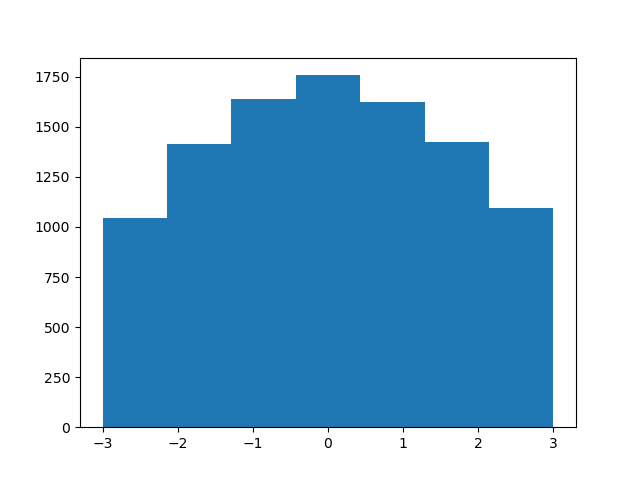

(array([1044., 1414., 1641., 1758., 1623., 1423., 1097.]),
 array([-3.        , -2.14285714, -1.28571429, -0.42857143,  0.42857143,
         1.28571429,  2.14285714,  3.        ]),
 <BarContainer object of 7 artists>)

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook
nums = rng.choice(x, size = 10000, p = prob)
plt.hist(nums, bins = len(x))

In [18]:
from functools import partial
idx = partial(rng.choice, x, size=1, p=prob)

In [19]:
idx()[0]

1

In [21]:
model.similar_by_word(str.lower('demandas'))[idx()[0]][0]

'peticiones'

In [22]:
rnd = rng.random
rnd()

0.6623638504136212

In [23]:
def similar_news(df, starting_id, p=0.4):
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    news_dicts = []
    for index, row in tqdm(df.reset_index().iterrows(), total=df.shape[0]):
        _dict = {'id' : starting_id + index,
                'title' : row.title + '--',
                'category' : row.category }
        texts_out = []
        doc = nlp(row.content)
        for token in doc:
            if token.pos_ != 'SPACE':
                if rnd() < p and token.pos_ in allowed_postags:
                    try:
                        replacement = model.similar_by_word(token.lower_, topn=topn)[idx()[0]][0]
                    except KeyError:
                        replacement = token.lower_
                else:
                    replacement = token.lower_
                texts_out.append(replacement)
        _dict['content'] = " ".join(texts_out)
        news_dicts.append(_dict)
    return pd.DataFrame(news_dicts)

In [24]:
nuevas = []
for (df, size_actual, min_id) in targets:
    df = df.sample((TARGET - size_actual), random_state=RANDOM_SEED)
    nuevas.append(similar_news(df, starting_id=min_id))
    
nuevas[0]

100%|█████████████████████████████████████████| 226/226 [20:07<00:00,  5.34s/it]


,id,title,category,content
0,20001000,Denuncian a Conchalí y San Ramón de tener caja...,5-Catástrofes_y_Accidentes,denuncian a conchalí y san ramón de tenido caj...
1,20001001,Onemi declara Alerta Roja para la comuna de Za...,5-Catástrofes_y_Accidentes,onemi declara alerta roja para la población de...
2,20001002,Declaran Alerta Roja en María Pinto y Melipil...,5-Catástrofes_y_Accidentes,declaran alerta roja en maría pinto y melipill...
3,20001003,Anciano permanece internado tras incendio de s...,5-Catástrofes_y_Accidentes,anciano permanece trasladado tras incendio de ...
4,20001004,[VIDEOS] El emotivo gesto navideño de Bomberos...,5-Catástrofes_y_Accidentes,[ videos ] el emotivo saludo festejo de bomber...
...,...,...,...,...
243,20001243,Viña del Mar: vecinos acusan falta de transpar...,5-Catástrofes_y_Accidentes,viña del mar : vecinos denuncian falta de tran...
244,20001244,ENAP paraliza una faena en Magallanes y mantie...,5-Catástrofes_y_Accidentes,enap paralizado una faena en magallanes y mant...
245,20001245,Transportistas forestales acusan que Poder Jud...,5-Catástrofes_y_Accidentes,transportistas forestal acusan que poder judic...
246,20001246,Alcalde de San Juan de la Costa acusa nula res...,5-Catástrofes_y_Accidentes,alcalde de san juan de la costa denunció nula ...


In [25]:
nuevas[0].to_csv('./datasets/generated_catastrofes.csv', index=False)
nuevas[1].to_csv('./datasets/generated_planeta.csv', index=False)

In [28]:
df = pd.read_csv('./datasets/dataset_paso3d96.csv')
df = pd.concat([df] + nuevas)
new_df = df.groupby('category').sample(n=TARGET, random_state=RANDOM_SEED)
new_df.reset_index(drop=True, inplace=True)
new_df.groupby('category').size().sort_values()

category
1-Mundo                        1678
10-Salud                       1678
2-Economía                     1678
3-Política_y_Conflictos        1678
4-Ciencias_y_Tecnología        1678
5-Catástrofes_y_Accidentes     1678
6-Cultura_y_Artes              1678
7-Deporte                      1678
8-Ecología_y_Planeta           1678
9-Crimen_delitos_y_Justicia    1678
dtype: int64

In [31]:
new_df.to_csv(f'./datasets/ds_balanced_gen_{TARGET}_rs{RANDOM_SEED}.csv', index=False)